<a href="https://colab.research.google.com/github/Hawawou/bach_pro/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
import time
from sklearn import svm

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Importing dataset
cols_list = ["Polarity", "Text"]
data = pd.read_csv(r'/content/drive/MyDrive/data.csv', usecols = cols_list)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clean and process tweets
stemmer = PorterStemmer()

def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp)  # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+", "", temp)  # remove mentions
    temp = re.sub("#[A-Za-z0-9_]+", "", temp)  # remove hashtags
    temp = re.sub(r'http\S+', '', temp)  # remove urls
    temp = re.sub('[()!?]', ' ', temp)  # remove special characters
    temp = re.sub('\[.*?\]', ' ', temp)
    temp = re.sub("[^a-z0-9]", " ", temp)  # convert all to lower case
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords.words('english')]
    temp = [stemmer.stem(word) for word in tweet]
    temp = " ".join(word for word in temp)
    return temp
data['Text'] = data['Text'].apply(clean_tweet) 


In [ ]:
# Distinguish tweets with positive and negative sentiments
data['Polarity'] = data['Polarity'].apply(lambda x: 1 if x == 'positive' else 0)

In [ ]:
data = data.loc[:, ['Text', 'Polarity']]

In [ ]:
# tokenization
tknzr = TweetTokenizer()
data["tokenized"] = [tknzr.tokenize(i) for i in data['Text']]

In [ ]:
# split data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=1)
X_train = train['Text'].values
X_test = test['Text'].values
y_train = train['Polarity']
y_test = test['Polarity']

In [ ]:
# vectorization
vectorizer = TfidfVectorizer(min_df=5,
                             max_df=0.8,
                             sublinear_tf=True,
                             use_idf=True)

train_vectors = vectorizer.fit_transform(train['Text'])
test_vectors = vectorizer.transform(test['Text'])

In [ ]:
print(train_vectors)

In [ ]:
print(test_vectors)

In [ ]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

In [ ]:
grid_svm.best_params_

In [ ]:
grid_svm.best_score_

0.8194288569286762

In [ ]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
report_results(grid_svm.best_estimator_, X_train, y_train)

{'acc': 0.822875,
 'auc': 0.8967972033490123,
 'f1': 0.8250617283950618,
 'precision': 0.8105518496058217,
 'recall': 0.840100565681961}

In [ ]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.75075,
 'auc': 0.8245222894090133,
 'f1': 0.7623361144219308,
 'precision': 0.7437209302325581,
 'recall': 0.7819070904645476}

In [ ]:
def get_roc_curve(model, X, y):
  pred_proba = model.predict_proba(X)[:, 1]
  fpr, tpr, _ = roc_curve(y, pred_proba)
  return fpr, tpr

In [ ]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

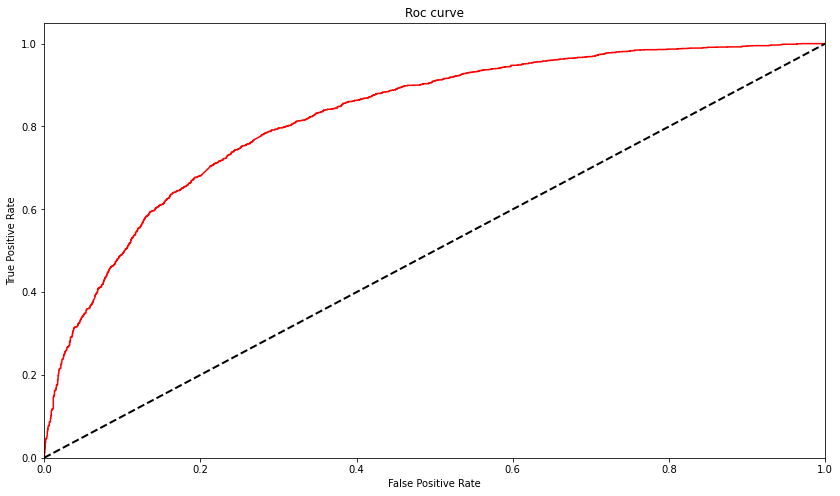

In [ ]:
import matplotlib.pyplot as plt
fpr, tpr = roc_svm
plt.figure(figsize = (14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
def plot_learning_curve(X, y, train_sizes, train_scores, ylim=None):
  plt.figure(figsize=(14, 8))
  plt.title('Learning curve')
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")

  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.fill_between(train_sizes, test_scores_mean, 'o-', color='r', label = "Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label = "Cross-validation score")
  plt.legend(loc="lower right")
  return plt
    

In [ ]:
plot_learning_curve(X_train, y_train, train_sizes, train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

NameError: ignored

In [ ]:
if grid_svm.predict == 1:
  print("This statement is positive")
else:
  print("This statement is negative")

In [ ]:
grid_svm.predict([" I wish you were here "])

array([0])

In [ ]:
grid_svm.predict(["You are an asshole"])

array([1])